In [1]:
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pickle as pkl

In [2]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'size':18})
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{helvet}\usepackage{sfmath}')

In [3]:
from GenomicTools.tools import *
from GenomicTools.tandem_duplications import *
from GenomicTools.synteny import *
from GenomicTools.dot_plots import *
from GenomicTools.permutations import *
from GenomicTools.dot_plots import *

# Dot plot, nanosynteny, and microsynteny

## Load data and do complexity analysis

In [4]:
spA, spB, dot_plot, dot_plot_labels = load_dot_plot('Homo_sapiens-Mus_musculus-dotplot.csv.gz')
spA, species_data_A, species_data_labels_A, chrom_info_A = load_species_data('Homo_sapiens_species_data.csv.gz')
spB, species_data_B, species_data_labels_B, chrom_info_B = load_species_data('Mus_musculus_species_data.csv.gz')

In [5]:
cc_maps_A, inv_cc_maps_A, shift_maps_A, unshift_maps_A = create_shift_map(species_data_A, 1)
cc_maps_B, inv_cc_maps_B, shift_maps_B, unshift_maps_B = create_shift_map(species_data_B, 1)

In [8]:
tandem_A = label_tandem(species_data_A,cc_maps_A,inv_cc_maps_A)
tandem_B = label_tandem(species_data_B,cc_maps_B,inv_cc_maps_B)

In [15]:
w = 10
H_A = find_entropy(species_data_A, chrom_info_A, w)
H_B = find_entropy(species_data_B, chrom_info_B, w)
tandem_H_A = find_tandem_entropy(species_data_A,chrom_info_A,cc_maps_A,w)
tandem_H_B = find_tandem_entropy(species_data_B,chrom_info_B,cc_maps_B,w)

## Run synteny analysis

In [18]:
rho, N_A, N_B = calculate_density(dot_plot,chrom_info_A,chrom_info_B)
kmin = k_min(.05, rho, N_A, N_B)

In [19]:
nano_params = {}
nano_params['dot_maxdist'] = 1
nano_params['block_minsize'] = kmin
nano_params['dist_cutoff'] = 30
nano_params['return_absolute_blocks'] = False

nano_blocks = run_synteny_identification(dot_plot,species_data_A,species_data_B,chrom_info_A,chrom_info_B,nano_params)

In [20]:
micro_params = {}
micro_params['dot_maxdist'] = 3
micro_params['block_minsize'] = kmin
micro_params['dist_cutoff'] = 30
micro_params['return_absolute_blocks'] = False

micro_blocks = run_synteny_identification(dot_plot,species_data_A,species_data_B,chrom_info_A,chrom_info_B,micro_params)

In [89]:
nano_supported = []
for block in nano_blocks:
    chromA = [key for key in chrom_info_A.keys() if chrom_info_A[key]['number'] == block[0,0]][0]
    chromB = [key for key in chrom_info_B.keys() if chrom_info_B[key]['number'] == block[0,2]][0]
    condensed_block = [[0,0,0,0]]
    for b in block:
        ccA = cc_maps_A[chromA][b[1]]
        ccB = cc_maps_B[chromB][b[3]]
        shiftedA = shift_maps_A[chromA][ccA]
        shiftedB = shift_maps_B[chromB][ccB]
        if (shiftedA != condensed_block[-1][1]) * (shiftedB != condensed_block[-1][3]):
            condensed_block.append([b[0],shiftedA,b[2],shiftedB])
        elif not (shiftedA == condensed_block[-1][1]) * (shiftedB == condensed_block[-1][3]):
            print('Uh oh...')
    nano_supported.append(supported_by_nanosynteny(np.vstack(condensed_block)[1:],kmin))
nano_supported = np.array(nano_supported)

In [90]:
np.all(nano_supported)

True

In [100]:
micro_supported = []
condensed_blocks = []
for block in micro_blocks:
    chromA = [key for key in chrom_info_A.keys() if chrom_info_A[key]['number'] == block[0,0]][0]
    chromB = [key for key in chrom_info_B.keys() if chrom_info_B[key]['number'] == block[0,2]][0]
    condensed_block = [[0,0,0,0]]
    for b in block:
        ccA = cc_maps_A[chromA][b[1]]
        ccB = cc_maps_B[chromB][b[3]]
        shiftedA = shift_maps_A[chromA][ccA]
        shiftedB = shift_maps_B[chromB][ccB]
        if (shiftedA != condensed_block[-1][1]) * (shiftedB != condensed_block[-1][3]):
            condensed_block.append([b[0],shiftedA,b[2],shiftedB])
        elif not (shiftedA == condensed_block[-1][1]) * (shiftedB == condensed_block[-1][3]):
            print('Uh oh...')
    micro_supported.append(supported_by_nanosynteny(np.vstack(condensed_block)[1:],kmin))
    
    condensed_blocks.append(np.vstack(condensed_block)[1:])
micro_supported = np.array(micro_supported)

In [94]:
np.all(micro_supported)

False

In [109]:
np.where(micro_supported == False)

(array([311]),)

In [99]:
supported_by_nanosynteny(micro_blocks[311],kmin)

True

In [102]:
condensed_blocks[311]

array([[  16,  246,    7, 1178],
       [  16,  247,    7, 1179]])

In [103]:
len(micro_blocks)

441

In [104]:
len(nano_blocks)

1456

In [105]:
h = np.unique([b.shape[0] for b in micro_blocks],return_counts=True)

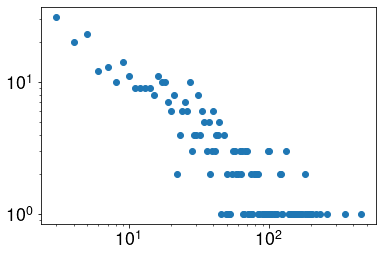

In [108]:
plt.scatter(h[0],h[1])
plt.xscale('log')
plt.yscale('log')

In [222]:
# adjacency = np.zeros((len(micro_blocks),len(micro_blocks)))
# overlaps = np.zeros((len(micro_blocks),len(micro_blocks)))
# intersections = {}
# for n1, b1 in enumerate(micro_blocks):
#     for n2, b2 in enumerate(micro_blocks):
#         if n1 == n2:
#             continue
#         else:
#             chromA1 = b1[0,0]
#             chromB1 = b1[0,2]
#             chromA2 = b2[0,0]
#             chromB2 = b2[0,2]
#             if (chromA1 == chromA2) and (chromB1 != chromB2):
#                 IA1 = b1[:,1]
#                 IA2 = b2[:,1]
#                 intersection = set(IA1).intersection(set(IA2))
#                 if len(intersection) > 2:
#                     adjacency[n1,n2] = 2
#                     overlaps[n1,n2] = len(intersection)
#                     intersections[(n1,n2)] = intersection
#             elif (chromA1 != chromA2) and (chromB1 == chromB2):
#                 IB1 = b1[:,3]
#                 IB2 = b2[:,3]
#                 intersection = set(IB1).intersection(set(IB2))
#                 if len(intersection) > 2:
#                     adjacency[n1,n2] = 1
#                     overlaps[n1,n2] = len(intersection)
#                     intersections[(n1,n2)] = intersection
#             elif (chromA1 == chromA2) and (chromB1 == chromB2):
#                 IA1 = b1[:,1]
#                 IA2 = b2[:,1]
#                 IB1 = b1[:,3]
#                 IB2 = b2[:,3]
#                 intersectionA = set(IA1).intersection(set(IA2))
#                 intersectionB = set(IB1).intersection(set(IB2))
#                 if (len(intersectionA) > 0) and (len(intersectionB) > 0):
#                     print('something is wrong... %i %i'%(n1,n2))
#                 elif len(intersectionA) > 2:
#                     adjacency[n1,n2] = 2
#                     overlaps[n1,n2] = len(intersection)
#                     intersections[(n1,n2)] = intersection
#                 elif len(intersectionB) > 2:
#                     adjacency[n1,n2] = 1
#                     overlaps[n1,n2] = len(intersection)
#                     intersections[(n1,n2)] = intersection

In [188]:
G = ntx.Graph(adjacency)

In [189]:
C = ntx.connected_components(G)
dups = []
for c in C:
    if len(c) > 3:
        dups.append(c)

In [295]:
abs_micro_blocks = convert_synteny_relative_to_absolute_indices(micro_blocks,chrom_info_A,chrom_info_B)

In [317]:
adjacency = np.zeros((len(abs_micro_blocks),len(abs_micro_blocks)))
overlaps = np.zeros((len(abs_micro_blocks),len(abs_micro_blocks)))
intersections = {}
for n1, b1 in enumerate(abs_micro_blocks):
    for n2, b2 in enumerate(abs_micro_blocks):
        if n1 == n2:
            continue
        else:
            IA1 = b1[:,0]
            IA2 = b2[:,0]
            IB1 = b1[:,1]
            IB2 = b2[:,1]
            intersectionA = set(IA1).intersection(set(IA2))
            intersectionB = set(IB1).intersection(set(IB2))
            if (len(intersectionA) > 0) and (len(intersectionB) > 0):
                print('something is wrong... %i %i'%(n1,n2))
            elif len(intersectionA) > 2:
                adjacency[n1,n2] = 2
                overlaps[n1,n2] = len(intersectionA)
                intersections[(n1,n2)] = intersectionA
            elif len(intersectionB) > 2:
                adjacency[n1,n2] = 1
                overlaps[n1,n2] = len(intersectionB)
                intersections[(n1,n2)] = intersectionB

In [302]:
len(dups)

4

In [308]:
d = dup_list[0]
neighbors = list(Gcc.neighbors(d))

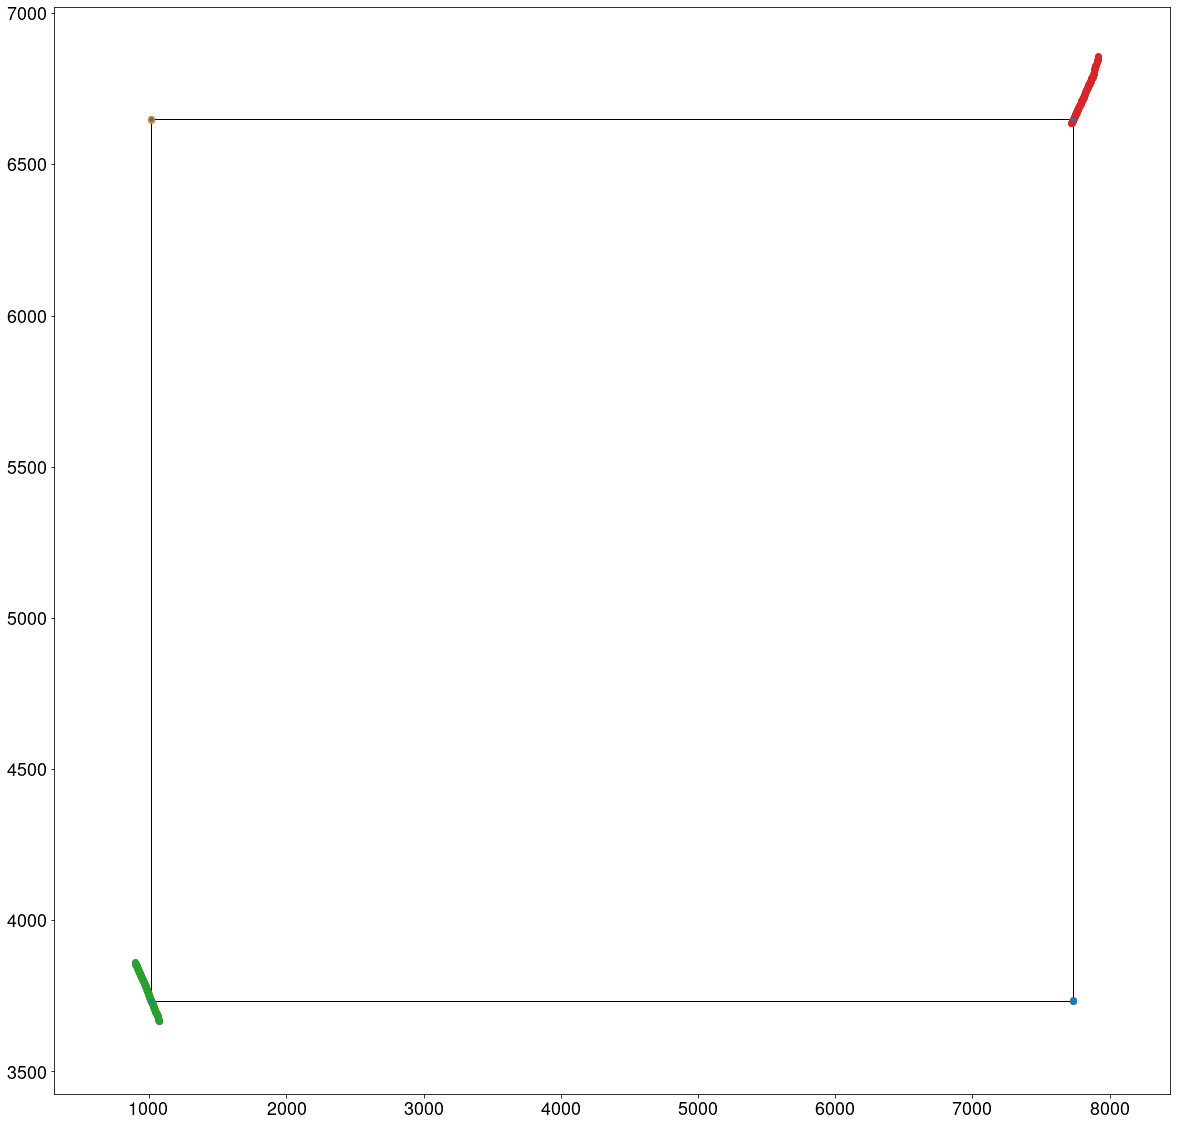

In [326]:
i = 0

Gcc = G.subgraph(dups[i])
dup_list = list(dups[i])
pos = {}
for d in dup_list:
    neighbors = list(Gcc.neighbors(d))
    weight = Gcc.get_edge_data(d,neighbors[0])['weight']
    if weight == 1:
        yd = list(intersections[(d,neighbors[0])])
        xd = []
        for y in yd:
            xd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,1] == y][0,0])
        pos[d] = [np.median(xd),np.median(yd)]
    elif weight == 2:
        xd = list(intersections[(d,neighbors[0])])
        yd = []
        for x in xd:
            yd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,0] == x][0,1])
        pos[d] = [np.median(xd),np.median(yd)]
        
fig, ax = plt.subplots(figsize=(20,20))

ntx.draw(G.subgraph(dups[i]),pos=pos,ax=ax,node_size=10)
for b in dups[i]:
    ax.scatter(abs_micro_blocks[b][:,0],abs_micro_blocks[b][:,1])
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

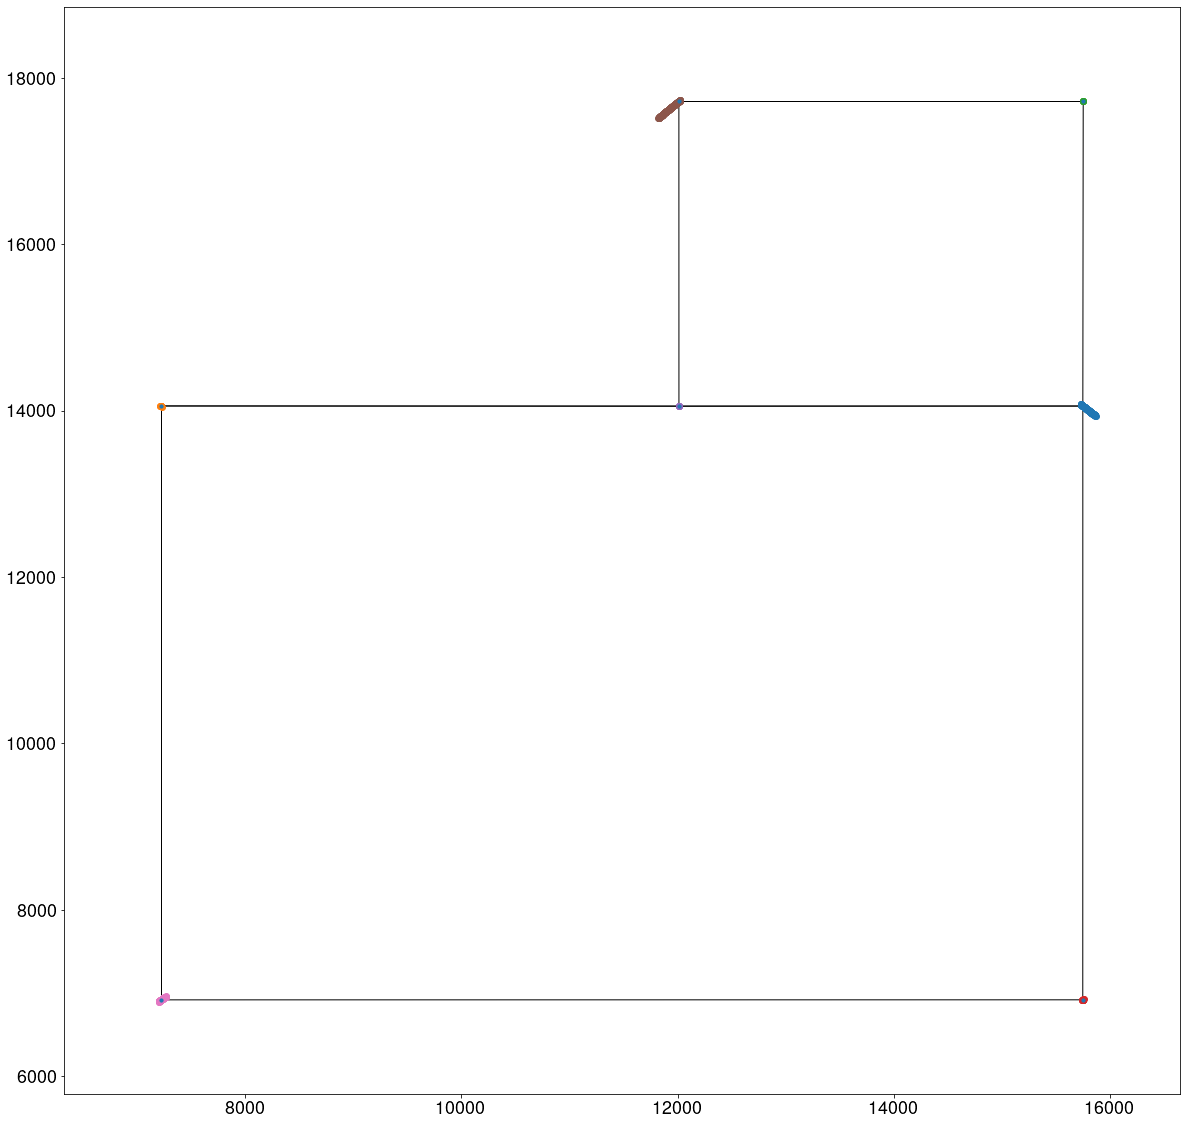

In [325]:
i = 1

Gcc = G.subgraph(dups[i])
dup_list = list(dups[i])
pos = {}
for d in dup_list:
    neighbors = list(Gcc.neighbors(d))
    weight = Gcc.get_edge_data(d,neighbors[0])['weight']
    if weight == 1:
        yd = list(intersections[(d,neighbors[0])])
        xd = []
        for y in yd:
            xd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,1] == y][0,0])
        pos[d] = [np.median(xd),np.median(yd)]
    elif weight == 2:
        xd = list(intersections[(d,neighbors[0])])
        yd = []
        for x in xd:
            yd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,0] == x][0,1])
        pos[d] = [np.median(xd),np.median(yd)]
        
fig, ax = plt.subplots(figsize=(20,20))

ntx.draw(G.subgraph(dups[i]),pos=pos,ax=ax,node_size=10)
for b in dups[i]:
    ax.scatter(abs_micro_blocks[b][:,0],abs_micro_blocks[b][:,1])
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

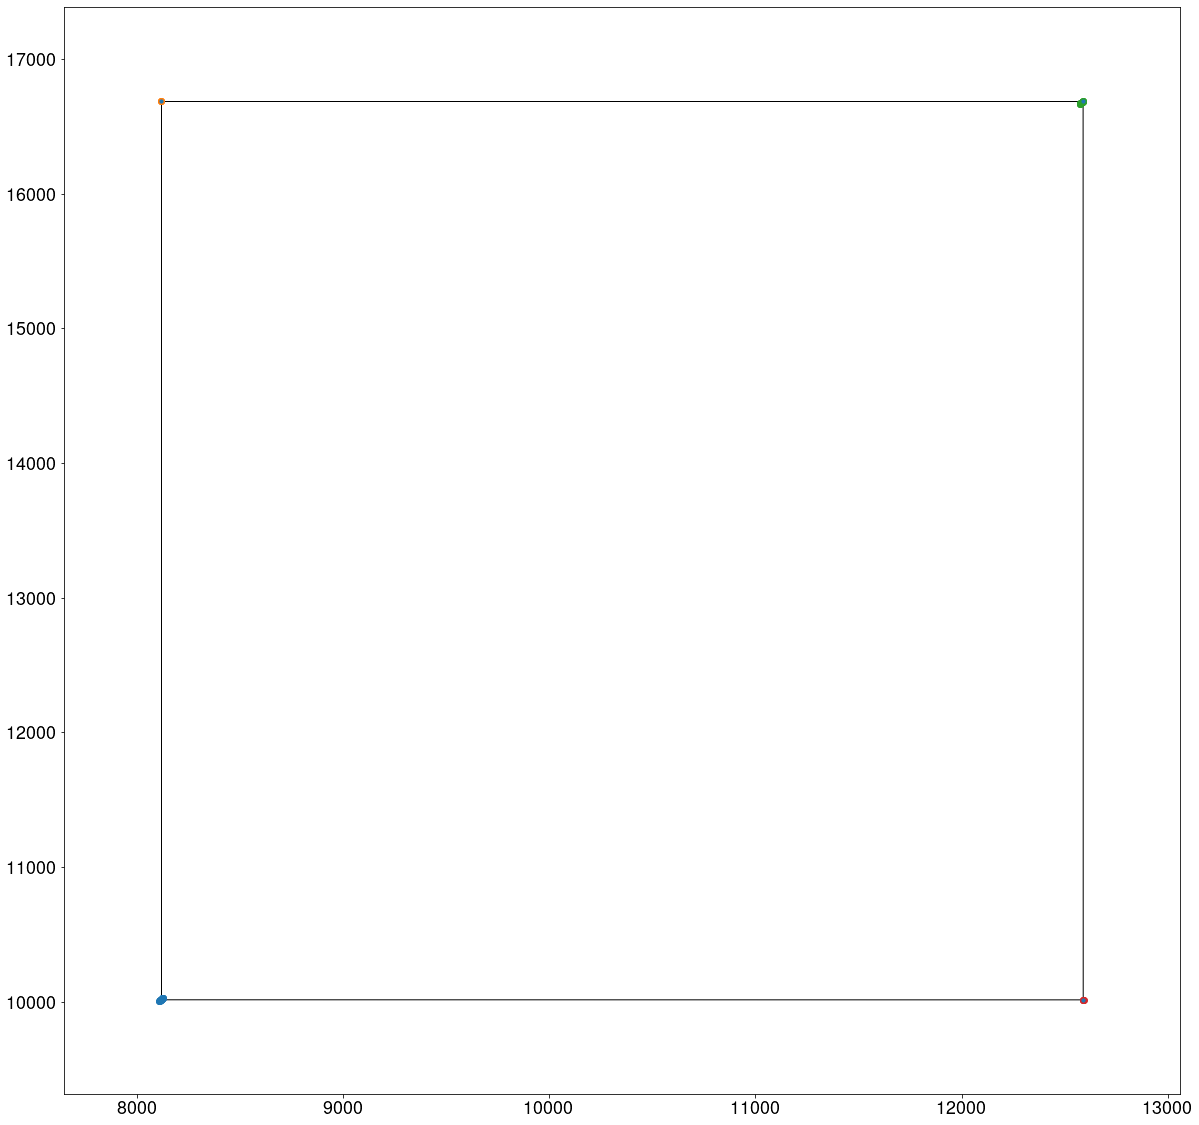

In [327]:
i = 2

Gcc = G.subgraph(dups[i])
dup_list = list(dups[i])
pos = {}
for d in dup_list:
    neighbors = list(Gcc.neighbors(d))
    weight = Gcc.get_edge_data(d,neighbors[0])['weight']
    if weight == 1:
        yd = list(intersections[(d,neighbors[0])])
        xd = []
        for y in yd:
            xd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,1] == y][0,0])
        pos[d] = [np.median(xd),np.median(yd)]
    elif weight == 2:
        xd = list(intersections[(d,neighbors[0])])
        yd = []
        for x in xd:
            yd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,0] == x][0,1])
        pos[d] = [np.median(xd),np.median(yd)]
        
fig, ax = plt.subplots(figsize=(20,20))

ntx.draw(G.subgraph(dups[i]),pos=pos,ax=ax,node_size=10)
for b in dups[i]:
    ax.scatter(abs_micro_blocks[b][:,0],abs_micro_blocks[b][:,1])
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

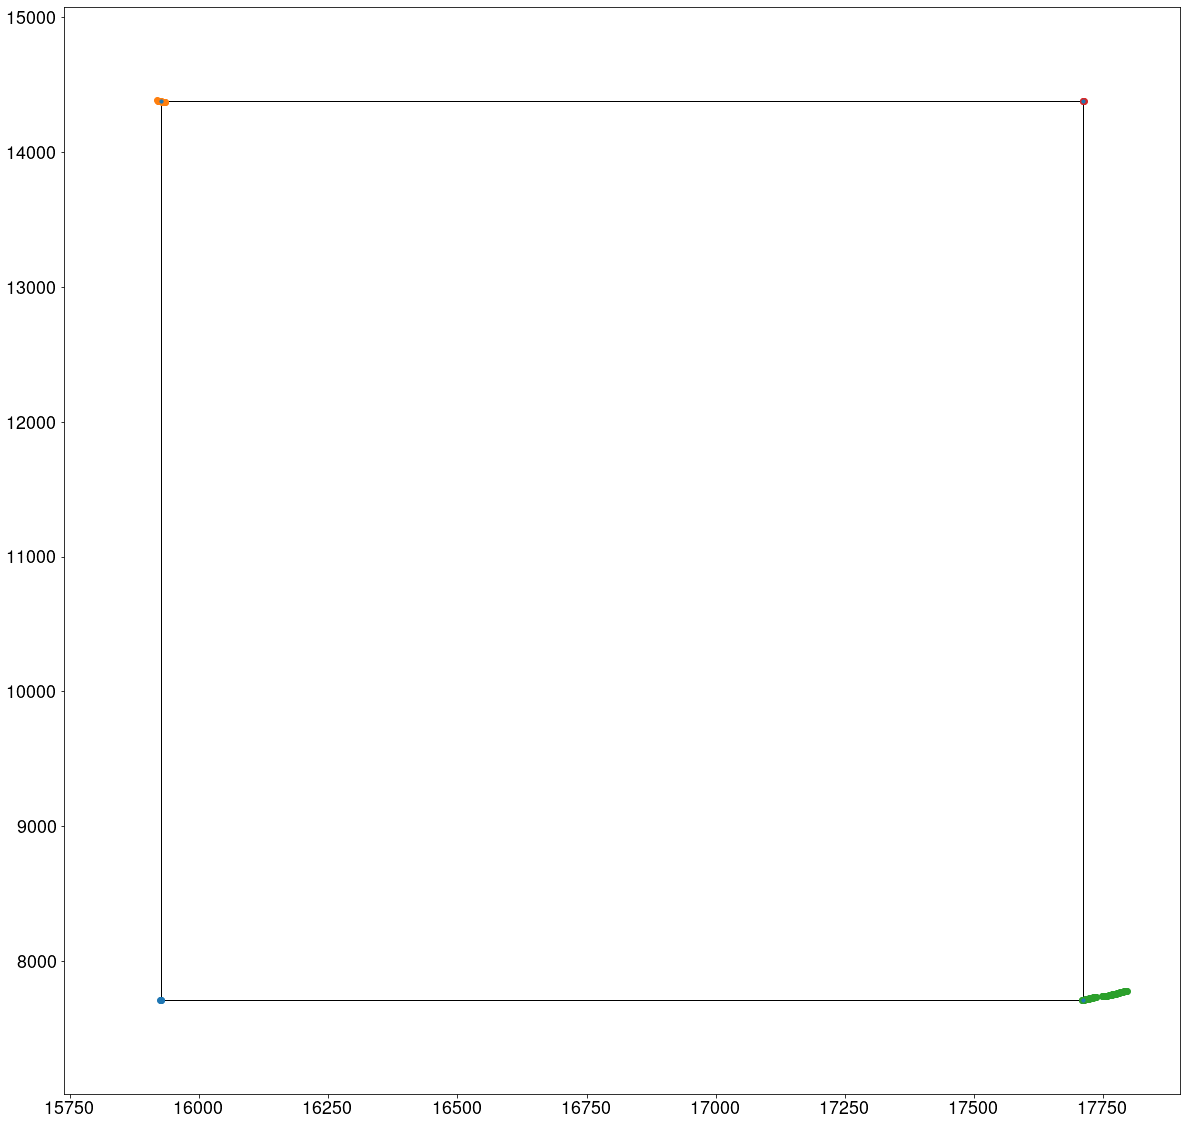

In [331]:
i = 3

Gcc = G.subgraph(dups[i])
dup_list = list(dups[i])
pos = {}
for d in dup_list:
    neighbors = list(Gcc.neighbors(d))
    weight = Gcc.get_edge_data(d,neighbors[0])['weight']
    if weight == 1:
        yd = list(intersections[(d,neighbors[0])])
        xd = []
        for y in yd:
            xd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,1] == y][0,0])
        pos[d] = [np.median(xd),np.median(yd)]
    elif weight == 2:
        xd = list(intersections[(d,neighbors[0])])
        yd = []
        for x in xd:
            yd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,0] == x][0,1])
        pos[d] = [np.median(xd),np.median(yd)]
        
fig, ax = plt.subplots(figsize=(20,20))

ntx.draw(G.subgraph(dups[i]),pos=pos,ax=ax,node_size=10)
for b in dups[i]:
    ax.scatter(abs_micro_blocks[b][:,0],abs_micro_blocks[b][:,1])
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

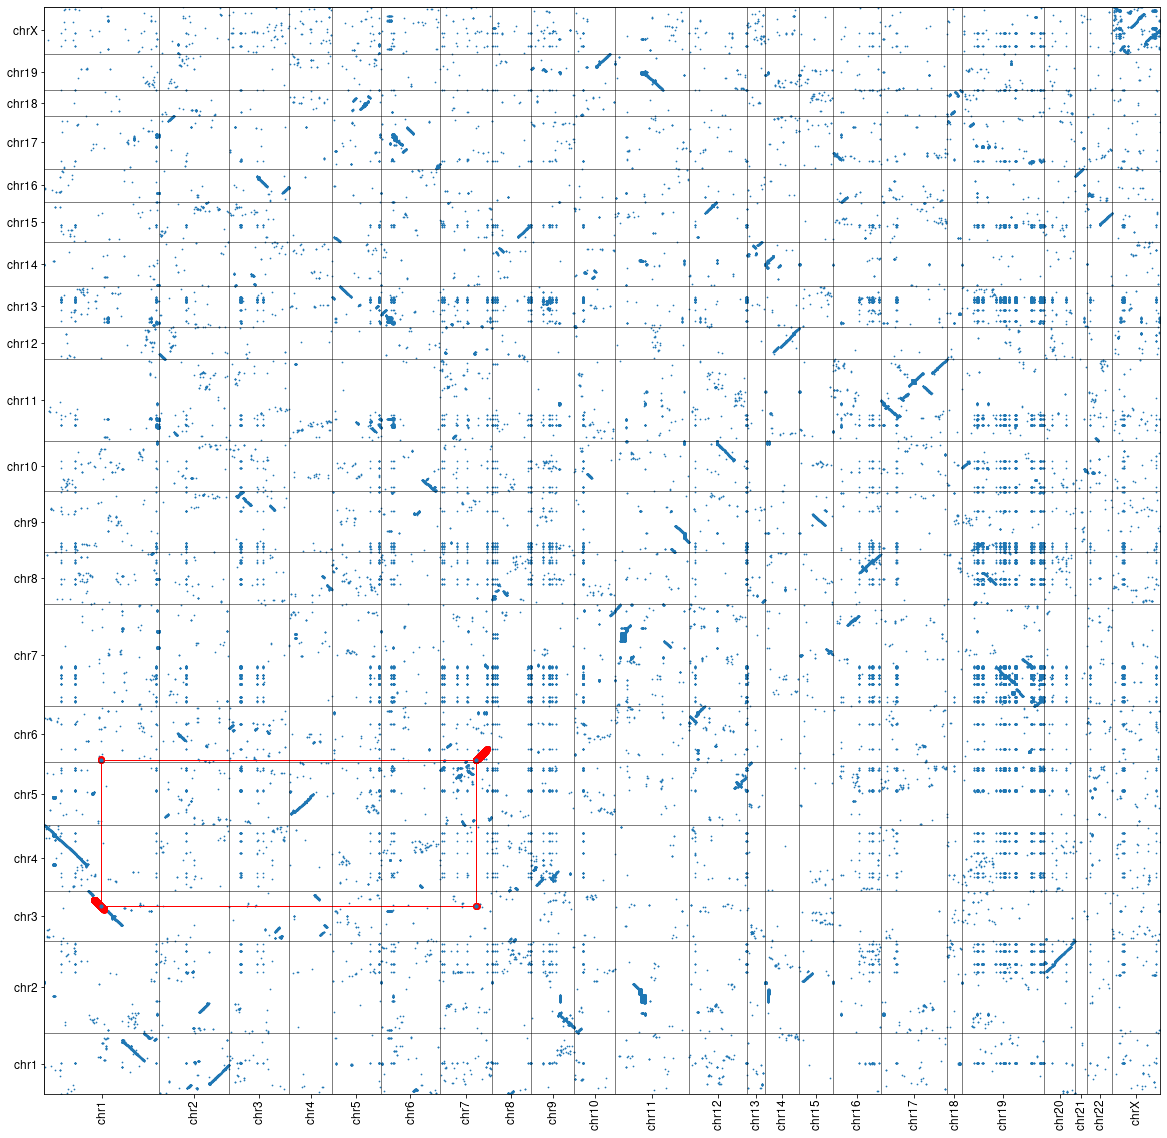

In [344]:
i = 0

fig, ax = plt.subplots(figsize=(20,20))
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,ax=ax)

Gcc = G.subgraph(dups[i])
dup_list = list(dups[i])
pos = {}
for d in dup_list:
    neighbors = list(Gcc.neighbors(d))
    weight = Gcc.get_edge_data(d,neighbors[0])['weight']
    if weight == 1:
        yd = list(intersections[(d,neighbors[0])])
        xd = []
        for y in yd:
            xd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,1] == y][0,0])
        pos[d] = [np.median(xd),np.median(yd)]
    elif weight == 2:
        xd = list(intersections[(d,neighbors[0])])
        yd = []
        for x in xd:
            yd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,0] == x][0,1])
        pos[d] = [np.median(xd),np.median(yd)]

ntx.draw(G.subgraph(dups[i]),pos=pos,ax=ax,node_size=10,edge_color='r')
for b in dups[i]:
    ax.scatter(abs_micro_blocks[b][:,0],abs_micro_blocks[b][:,1],c='r')
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

In [560]:
1e8 / (1e6)

100.0

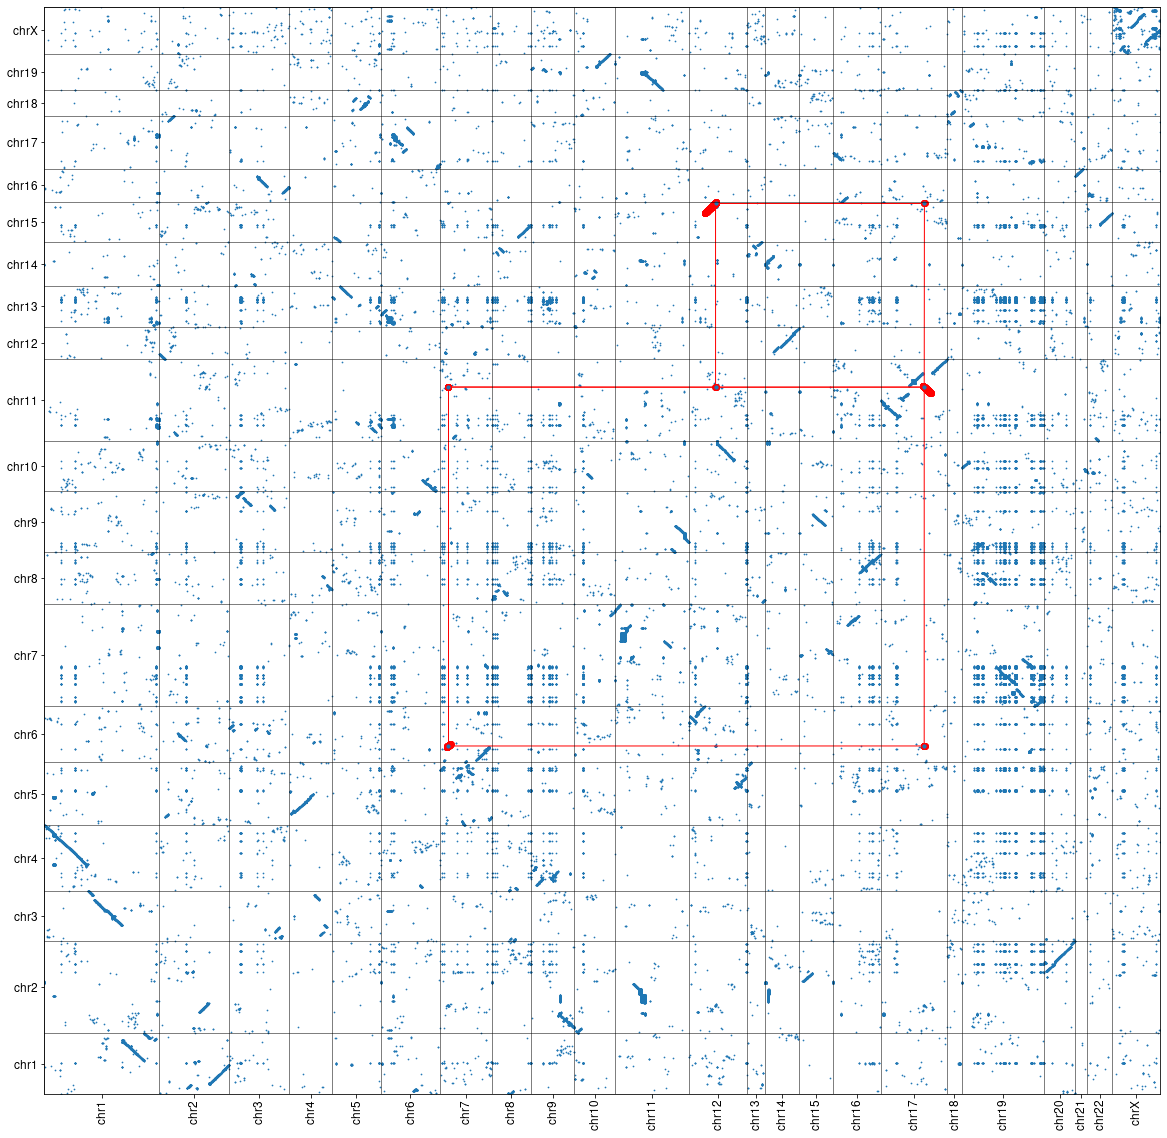

In [345]:
i = 1

fig, ax = plt.subplots(figsize=(20,20))
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,ax=ax)

Gcc = G.subgraph(dups[i])
dup_list = list(dups[i])
pos = {}
for d in dup_list:
    neighbors = list(Gcc.neighbors(d))
    weight = Gcc.get_edge_data(d,neighbors[0])['weight']
    if weight == 1:
        yd = list(intersections[(d,neighbors[0])])
        xd = []
        for y in yd:
            xd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,1] == y][0,0])
        pos[d] = [np.median(xd),np.median(yd)]
    elif weight == 2:
        xd = list(intersections[(d,neighbors[0])])
        yd = []
        for x in xd:
            yd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,0] == x][0,1])
        pos[d] = [np.median(xd),np.median(yd)]

ntx.draw(G.subgraph(dups[i]),pos=pos,ax=ax,node_size=10,edge_color='r')
for b in dups[i]:
    ax.scatter(abs_micro_blocks[b][:,0],abs_micro_blocks[b][:,1],c='r')
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

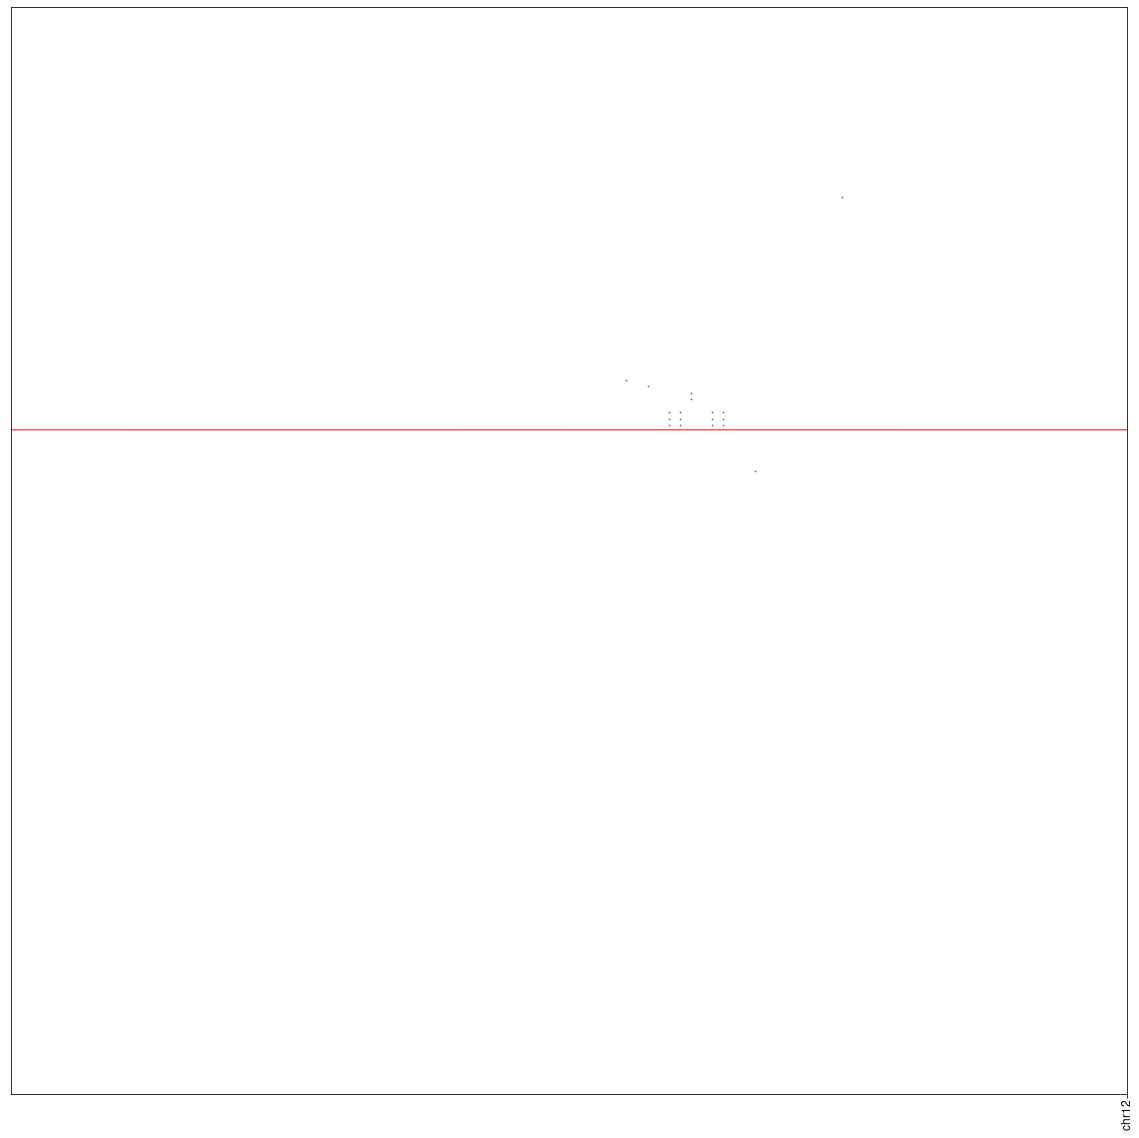

In [343]:
fig, ax = plt.subplots(figsize=(20,20))
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,ax=ax,xlim=12,ylim=6,xfrac_lim=[.4,.5],yfrac_lim=[.2,.35])

i = 1

Gcc = G.subgraph(dups[i])
dup_list = list(dups[i])
pos = {}
for d in dup_list:
    neighbors = list(Gcc.neighbors(d))
    weight = Gcc.get_edge_data(d,neighbors[0])['weight']
    if weight == 1:
        yd = list(intersections[(d,neighbors[0])])
        xd = []
        for y in yd:
            xd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,1] == y][0,0])
        pos[d] = [np.median(xd),np.median(yd)]
    elif weight == 2:
        xd = list(intersections[(d,neighbors[0])])
        yd = []
        for x in xd:
            yd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,0] == x][0,1])
        pos[d] = [np.median(xd),np.median(yd)]

ntx.draw(G.subgraph(dups[i]),pos=pos,ax=ax,node_size=10,edge_color='r')
for b in dups[i]:
    ax.scatter(abs_micro_blocks[b][:,0],abs_micro_blocks[b][:,1],c='r')
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

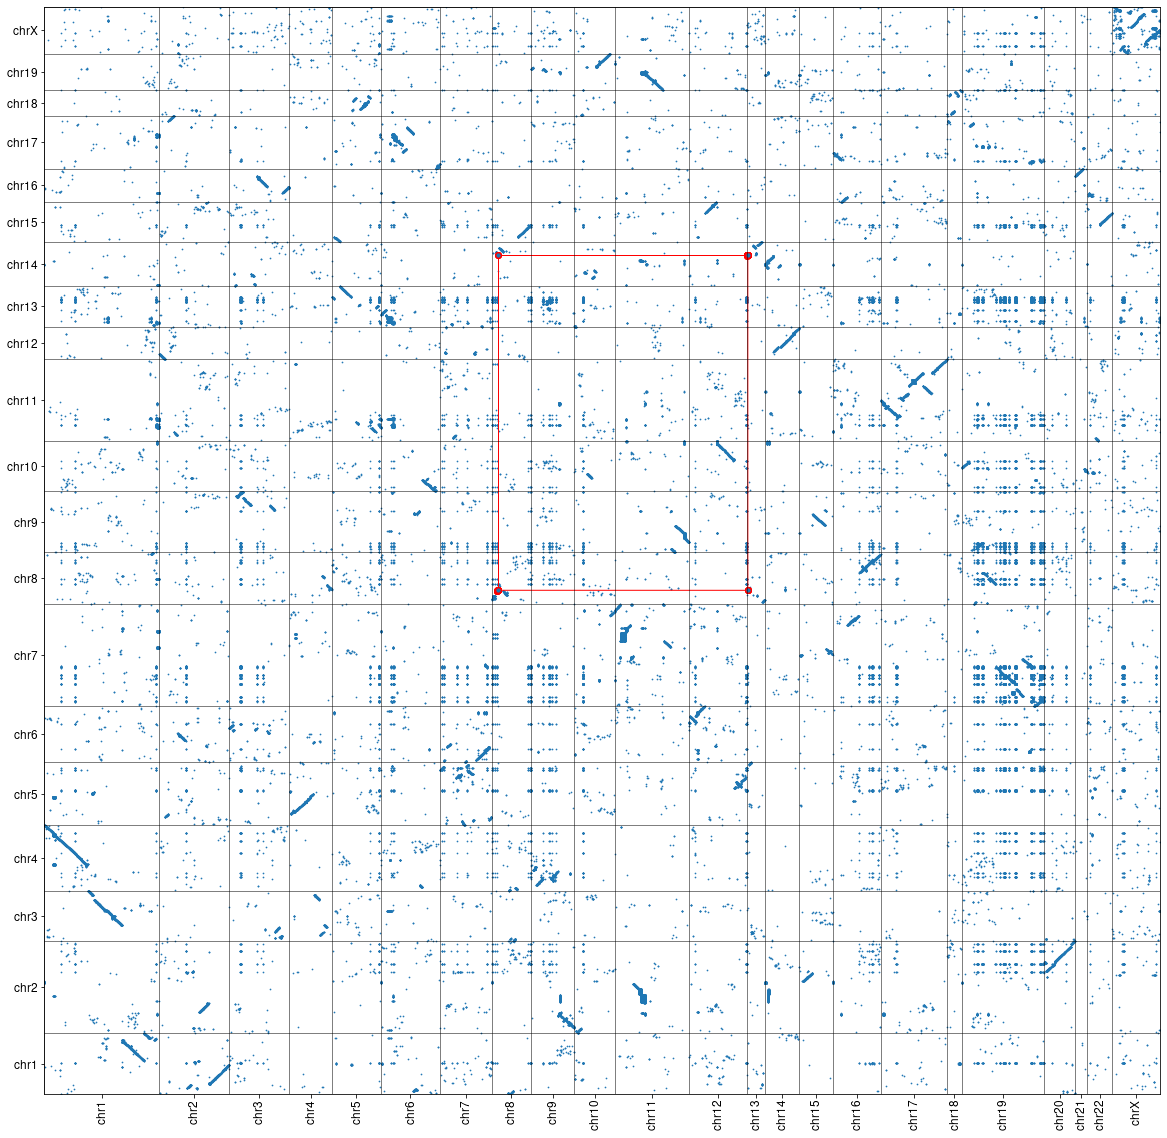

In [346]:
i = 2

fig, ax = plt.subplots(figsize=(20,20))
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,ax=ax)

Gcc = G.subgraph(dups[i])
dup_list = list(dups[i])
pos = {}
for d in dup_list:
    neighbors = list(Gcc.neighbors(d))
    weight = Gcc.get_edge_data(d,neighbors[0])['weight']
    if weight == 1:
        yd = list(intersections[(d,neighbors[0])])
        xd = []
        for y in yd:
            xd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,1] == y][0,0])
        pos[d] = [np.median(xd),np.median(yd)]
    elif weight == 2:
        xd = list(intersections[(d,neighbors[0])])
        yd = []
        for x in xd:
            yd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,0] == x][0,1])
        pos[d] = [np.median(xd),np.median(yd)]

ntx.draw(G.subgraph(dups[i]),pos=pos,ax=ax,node_size=10,edge_color='r')
for b in dups[i]:
    ax.scatter(abs_micro_blocks[b][:,0],abs_micro_blocks[b][:,1],c='r')
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

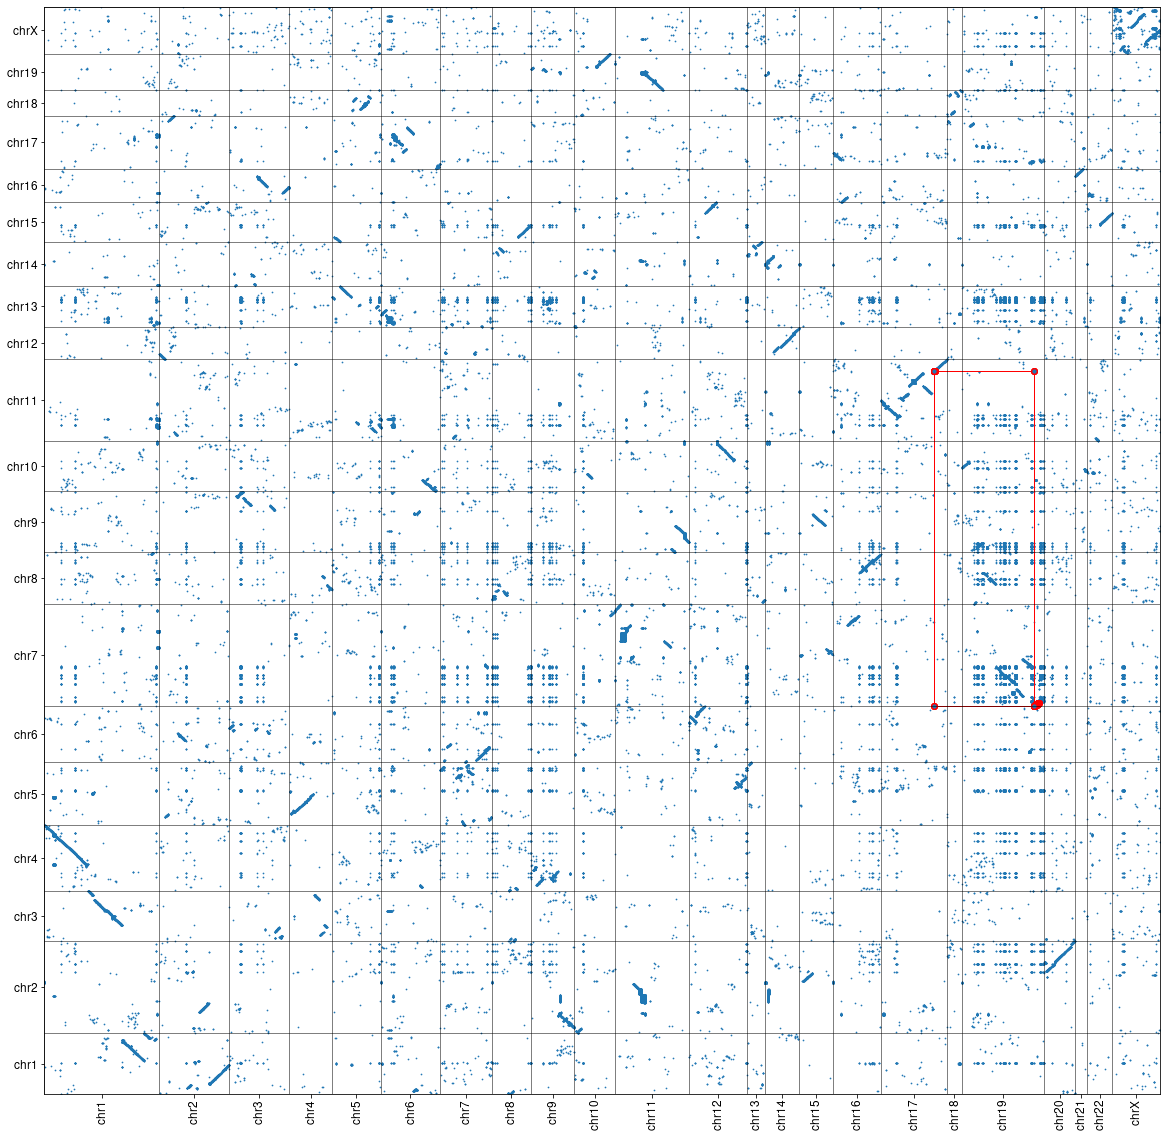

In [347]:
i = 3

fig, ax = plt.subplots(figsize=(20,20))
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,ax=ax)

Gcc = G.subgraph(dups[i])
dup_list = list(dups[i])
pos = {}
for d in dup_list:
    neighbors = list(Gcc.neighbors(d))
    weight = Gcc.get_edge_data(d,neighbors[0])['weight']
    if weight == 1:
        yd = list(intersections[(d,neighbors[0])])
        xd = []
        for y in yd:
            xd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,1] == y][0,0])
        pos[d] = [np.median(xd),np.median(yd)]
    elif weight == 2:
        xd = list(intersections[(d,neighbors[0])])
        yd = []
        for x in xd:
            yd.append(abs_micro_blocks[d][abs_micro_blocks[d][:,0] == x][0,1])
        pos[d] = [np.median(xd),np.median(yd)]

ntx.draw(G.subgraph(dups[i]),pos=pos,ax=ax,node_size=10,edge_color='r')
for b in dups[i]:
    ax.scatter(abs_micro_blocks[b][:,0],abs_micro_blocks[b][:,1],c='r')
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

In [113]:
b1 = micro_blocks[0]
b2 = micro_blocks[1]

In [118]:
chromA1 = b1[0,0]
chromB1 = b1[0,2]
chromA2 = b2[0,0]
chromB2 = b2[0,2]

In [ ]:
if (chromA1 == chromA2) and (chromB1 != chromB2):
    IA1 = b1[:,1]
    IA2 = b2[:,1]
    intersection = set(IA1).intersection(set(IA2))
    if len(intersection) > 2:
        overlaps[n1,n2] = 2
elif (chromA1 != chromA2) and (chromB1 == chromB2):
    IB1 = b1[:,3]
    IB2 = b2[:,3]
    intersection = set(IB1).intersection(set(IB2))
    if len(intersection) > 2:
        overlaps[n1,n2] = 1
elif (chromA1 == chromA2) and (chromB1 == chromB2):
    IA1 = b1[:,1]
    IA2 = b2[:,1]
    IB1 = b1[:,3]
    IB2 = b2[:,3]
    intersectionA = set(IA1).intersection(set(IA2))
    intersectionB = set(IB1).intersection(set(IB2))
    if (len(intersectionA) > 0) and (len(intersectionB) > 0):
        print('something is wrong...')
    elif len(intersectionA) > 2:
        overlaps[n1,n2] = 2
    elif len(intersectionB) > 2:
        overlaps[n1,n2] = 1

In [119]:
IA1 = b1[:,1]

In [120]:
IA1

array([1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874])

In [115]:
b2

array([[   1, 1971,    1, 1073],
       [   1, 1972,    1, 1074],
       [   1, 1973,    1, 1075],
       [   1, 1974,    1, 1076],
       [   1, 1975,    1, 1077],
       [   1, 1976,    1, 1078],
       [   1, 1977,    1, 1079],
       [   1, 1978,    1, 1080],
       [   1, 1979,    1, 1081],
       [   1, 1981,    1, 1082],
       [   1, 1982,    1, 1084],
       [   1, 1983,    1, 1085],
       [   1, 1984,    1, 1086],
       [   1, 1985,    1, 1087],
       [   1, 1986,    1, 1088],
       [   1, 1987,    1, 1089],
       [   1, 1988,    1, 1090],
       [   1, 1989,    1, 1092],
       [   1, 1991,    1, 1093],
       [   1, 1992,    1, 1094],
       [   1, 1993,    1, 1095],
       [   1, 1994,    1, 1096],
       [   1, 1995,    1, 1097],
       [   1, 1996,    1, 1098],
       [   1, 1997,    1, 1099],
       [   1, 1998,    1, 1100],
       [   1, 1999,    1, 1102]])

In [61]:
block = nano_blocks[653]
chromA = [key for key in chrom_info_A.keys() if chrom_info_A[key]['number'] == block[0,0]][0]
chromB = [key for key in chrom_info_B.keys() if chrom_info_B[key]['number'] == block[0,2]][0]
condensed_block = []
for b in block:
    ccA = cc_maps_A[chromA][b[1]]
    ccB = cc_maps_B[chromB][b[3]]
    condensed_block.append([b[0],shift_maps_A[chromA][ccA],b[2],shift_maps_B[chromB][ccB]])

In [74]:
XY = dot_plot[(dot_plot[:,0]=='chr8')*(dot_plot[:,2]=='chr15')][:,[1,3]].astype(int)

(240.0, 260.0)

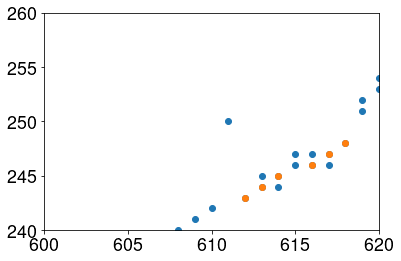

In [77]:
plt.scatter(XY[:,0],XY[:,1])
plt.scatter(block[:,1],block[:,3])
plt.xlim([600,620])
plt.ylim([240,260])

In [63]:
block

array([[  8, 612,  15, 243],
       [  8, 613,  15, 244],
       [  8, 614,  15, 245],
       [  8, 616,  15, 246],
       [  8, 617,  15, 247],
       [  8, 618,  15, 248]])

In [69]:
condensed_block = []
for b in block:
    ccA = cc_maps_A[chromA][b[1]]
    ccB = cc_maps_B[chromB][b[3]]
    condensed_block.append([ccA,ccB])

In [71]:
np.vstack(condensed_block)

array([[562, 231],
       [563, 232],
       [563, 232],
       [564, 233],
       [564, 233],
       [565, 234]])

In [68]:
inv_cc_maps_A

{'chr1': {0: array([1]),
  1: array([2, 3]),
  2: array([4]),
  3: array([5]),
  4: array([6]),
  5: array([7]),
  6: array([8]),
  7: array([9]),
  8: array([10]),
  9: array([11]),
  10: array([12]),
  11: array([13]),
  12: array([14]),
  13: array([15]),
  14: array([16]),
  15: array([17]),
  16: array([18]),
  17: array([19]),
  18: array([20]),
  19: array([21]),
  20: array([22]),
  21: array([23]),
  22: array([24]),
  23: array([25]),
  24: array([26]),
  25: array([27]),
  26: array([28]),
  27: array([29]),
  28: array([30]),
  29: array([31]),
  30: array([32]),
  31: array([33]),
  32: array([34]),
  33: array([35, 36, 37]),
  34: array([38]),
  35: array([39]),
  36: array([40]),
  37: array([41]),
  38: array([42]),
  39: array([43]),
  40: array([44]),
  41: array([45]),
  42: array([46]),
  43: array([47]),
  44: array([48]),
  45: array([49]),
  46: array([50]),
  47: array([51]),
  48: array([52]),
  49: array([53]),
  50: array([54]),
  51: array([55]),
  52: array

In [62]:
condensed_block

[[8, 563, 15, 232],
 [8, 564, 15, 233],
 [8, 564, 15, 233],
 [8, 565, 15, 234],
 [8, 565, 15, 234],
 [8, 566, 15, 235]]

In [57]:
np.where(nano_supported == False)

(array([ 653,  664,  802,  896, 1308]),)

In [39]:
species_data_A[species_data_A[:,0] == 'chr1']

array([['chr1', '1', '1', ..., '', '', ''],
       ['chr1', '1', '2', ..., '', '', ''],
       ['chr1', '1', '3', ..., '', '', ''],
       ...,
       ['chr1', '1', '2059', ..., '', '', ''],
       ['chr1', '1', '2060', ..., '', '', ''],
       ['chr1', '1', '2061', ..., '', '', '']], dtype='<U23')

In [46]:
np.max(list(inv_cc_maps_A['chr1'].values()))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1860,) + inhomogeneous part.

In [48]:
np.max(list(cc_maps_A['chr1'].values()))

1859

In [43]:
chrom_info_A['chr1']

{'number': 1, 'size': 2061}

In [32]:
shift_maps_A[chromA].values()

dict_values([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

NameError: name 'chromA' is not defined

In [26]:
[key for key in chrom_info_A.keys() if chrom_info_A[key]['number'] == 1][0]

'chr1'

{'chr1': {0: 1,
  1: 2,
  2: 3,
  3: 4,
  4: 5,
  5: 6,
  6: 7,
  7: 8,
  8: 9,
  9: 10,
  10: 11,
  11: 12,
  12: 13,
  13: 14,
  14: 15,
  15: 16,
  16: 17,
  17: 18,
  18: 19,
  19: 20,
  20: 21,
  21: 22,
  22: 23,
  23: 24,
  24: 25,
  25: 26,
  26: 27,
  27: 28,
  28: 29,
  29: 30,
  30: 31,
  31: 32,
  32: 33,
  33: 34,
  34: 35,
  35: 36,
  36: 37,
  37: 38,
  38: 39,
  39: 40,
  40: 41,
  41: 42,
  42: 43,
  43: 44,
  44: 45,
  45: 46,
  46: 47,
  47: 48,
  48: 49,
  49: 50,
  50: 51,
  51: 52,
  52: 53,
  53: 54,
  54: 55,
  55: 56,
  56: 57,
  57: 58,
  58: 59,
  59: 60,
  60: 61,
  61: 62,
  62: 63,
  63: 64,
  64: 65,
  65: 66,
  66: 67,
  67: 68,
  68: 69,
  69: 70,
  70: 71,
  71: 72,
  72: 73,
  73: 74,
  74: 75,
  75: 76,
  76: 77,
  77: 78,
  78: 79,
  79: 80,
  80: 81,
  81: 82,
  82: 83,
  83: 84,
  84: 85,
  85: 86,
  86: 87,
  87: 88,
  88: 89,
  89: 90,
  90: 91,
  91: 92,
  92: 93,
  93: 94,
  94: 95,
  95: 96,
  96: 97,
  97: 98,
  98: 99,
  99: 100,
  100: 101

In [ ]:
w = 10

tandem = label_tandem(species_data,cc_maps,inv_cc_maps)
H = find_entropy(species_data,chrom_info,w)
tandem_H = find_tandem_entropy(species_data,chrom_info,cc_maps,w)

species_data_labels[7] = 'tandem dup'
species_data[:,7] = tandem
species_data_labels[8] = 'H-w%i'%w
species_data[:,8] = H
species_data_labels[9] = 'tandem H-w%i'%w
species_data[:,9] = tandem_H

In [416]:
species_data_labels_A[7] = 'tandem dup'
species_data_A[:,7] = tandem_A
species_data_labels_B[7] = 'tandem dup'
species_data_B[:,7] = tandem_B

species_data_labels_A[8] = 'H-w10'
species_data_A[:,8] = H_A
species_data_labels_B[8] = 'H-w10'
species_data_B[:,8] = H_B

species_data_labels_A[9] = 'tandem H-w10'
species_data_A[:,9] = tandem_H_A
species_data_labels_B[9] = 'tandem H-w10'
species_data_B[:,9] = tandem_H_B

(0.0, 2000.0)

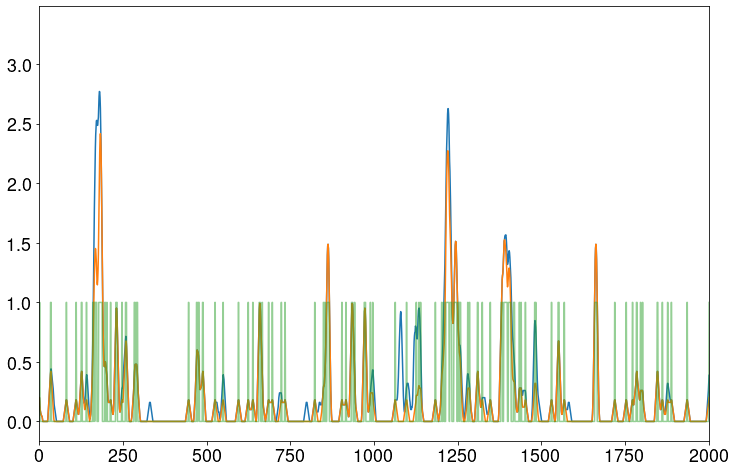

In [412]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(-np.log2(1/10)-H_A)
ax.plot(-np.log2(1/10)-tandem_H_A)
ax.plot(tandem_A,alpha=.5)
ax.set_xlim(0,2000)

(0.0, 5000.0)

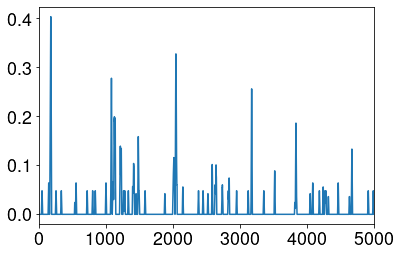

In [120]:
plt.plot((-H_A+tandem_H_A)/-np.log2(1/10))
plt.xlim(0,5000)

In [171]:
block = nano_blocks[0]

In [172]:
block_A = species_data_A[species_data_A[:,1].astype(int) == block[0,0]][block[:,1]-1]
block_B = species_data_B[species_data_B[:,1].astype(int) == block[0,2]][block[:,3]-1]

In [177]:
block_A

array([['chr1', '1', '1866', '1866', '2134', 'ENSG00000143753.13',
        'DEGS1', '1', '3.201928094887362', '3.201928094887362', '', ''],
       ['chr1', '1', '1867', '1867', '7144', 'ENSG00000143748.18', 'NVL',
        '1', '3.2219280948873625', '3.2219280948873625', '', ''],
       ['chr1', '1', '1868', '1868', '3996', 'ENSG00000143771.12',
        'CNIH4', '1', '3.241928094887362', '3.241928094887362', '', ''],
       ['chr1', '1', '1869', '1869', '6921', 'ENSG00000162923.18',
        'WDR26', '1', '3.261928094887362', '3.261928094887362', '', ''],
       ['chr1', '1', '1870', '1870', '455', 'ENSG00000143786.8', 'CNIH3',
        '1', '3.2619280948873617', '3.261928094887362', '', '']],
      dtype='<U23')

In [175]:
block_A[:,7]

array(['1', '1', '1', '1', '1'], dtype='<U23')

In [174]:
block_B[:,7]

array(['0', '0', '0', '0', '0'], dtype='<U21')

In [123]:
non_tandem_H_norm_A = (-H_A+tandem_H_A)/-np.log2(1/10)

In [126]:
h_ntHnA = np.histogram(non_tandem_H_norm_A,bins=100)

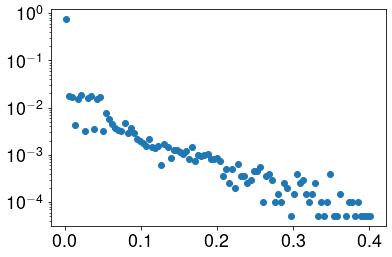

In [131]:
plt.scatter((h_ntHnA[1][1:]+h_ntHnA[1][:-1])/2,h_ntHnA[0]/h_ntHnA[0].sum())
plt.yscale('log')

(0.0, 2061.0)

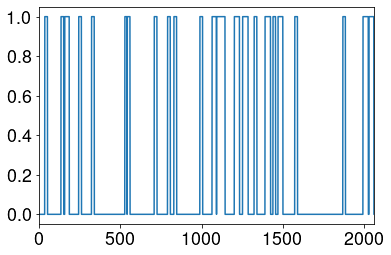

In [158]:
plt.plot(non_tandem_H_norm_A > 1e-5)
plt.xlim(0,2061)

In [155]:
np.sum(non_tandem_H_norm_A < 1e-5) / non_tandem_H_norm_A.shape[0]

0.7627466693378744

In [149]:
F_tHA = np.cumsum(np.sort(non_tandem_H_norm_A)) / np.sum(non_tandem_H_norm_A)

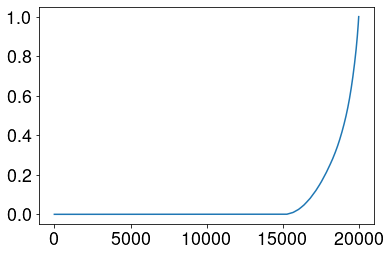

In [153]:
plt.plot(F_tHA)

In [147]:
np.sort(non_tandem_H_norm_A)[15000]

1.3368417291558519e-16

In [144]:
np.abs(np.cumsum(np.sort(non_tandem_H_norm_A)) / np.sum(non_tandem_H_norm_A) - .95).argmin()

19923

In [145]:
np.sort(non_tandem_H_norm_A)[19923]

0.3162580496177894

In [23]:
species_data_B[species_data_B[:,0] == 'chr1'][1040:1050]

array([['chr1', '1', '1041', '1041', '11759', 'ENSMUSG00000037872.6',
        'Ackr1', '', '', '', '', ''],
       ['chr1', '1', '1042', '1042', '9882', 'ENSMUSG00000005338.15',
        'Cadm3', '', '', '', '', ''],
       ['chr1', '1', '1043', '1043', '843', 'ENSMUSG00000037860.16',
        'Aim2', '', '', '', '', ''],
       ['chr1', '1', '1044', '1044', '843', 'ENSMUSG00000037849.9',
        'Ifi206', '', '', '', '', ''],
       ['chr1', '1', '1045', '1045', '843', 'ENSMUSG00000070501.15',
        'Ifi214', '', '', '', '', ''],
       ['chr1', '1', '1046', '1046', '843', 'ENSMUSG00000073491.12',
        'Ifi213', '', '', '', '', ''],
       ['chr1', '1', '1047', '1047', '843', 'ENSMUSG00000043263.14',
        'Ifi209', '', '', '', '', ''],
       ['chr1', '1', '1048', '1048', '16386', 'ENSMUSG00000066677.13',
        'Ifi208', '', '', '', '', ''],
       ['chr1', '1', '1049', '1049', '843', 'ENSMUSG00000073490.12',
        'Ifi207', '', '', '', '', ''],
       ['chr1', '1', '1050', 

In [20]:
nano_blocks[6]

array([[   1, 1412,    1, 1047],
       [   1, 1413,    1, 1042],
       [   1, 1414,    1, 1041]])

In [19]:
np.where(nano_supported == False)

(array([   6,   11,   65,   75,  143,  179,  360,  371,  389,  481,  491,
         496,  510,  524,  555,  572,  602,  629,  719,  754,  797,  834,
         843,  895, 1019, 1109, 1124, 1174, 1298, 1314, 1320, 1337, 1366,
        1448]),)

In [17]:
np.all(nano_supported)

False

In [7]:
#if os.path.isfile('Homo_sapiens-Mus_musculus_synteny_block_results.pkl'):
nano_blocks, micro_blocks, nblocks_with_maxdist, synteny_blocks_with_maxdist, synteny_coverage_with_maxdist = pkl.load(open('Homo_sapiens-Mus_musculus_synteny_block_results.pkl','rb'))
# if os.path.isfile('Homo_sapiens-Mus_musculus_permutation_results.pkl'):
#     pearson_with_perm, permutation_block_matrix = pkl.load(open('Homo_sapiens-Mus_musculus_permutation_results.pkl','rb'))
#     permuted_dot_plots = {}
#     for maxdist in range(0,31,3):
#         perm_spA, perm_spB, perm_dot_plot, perm_labels = load_dot_plot('Homo_sapiens-Mus_musculus-permuted_dotplot_%i_swaps.csv.gz'%maxdist)
#         permuted_dot_plots[maxdist] = perm_dot_plot

ValueError: not enough values to unpack (expected 5, got 4)

## Dot plot

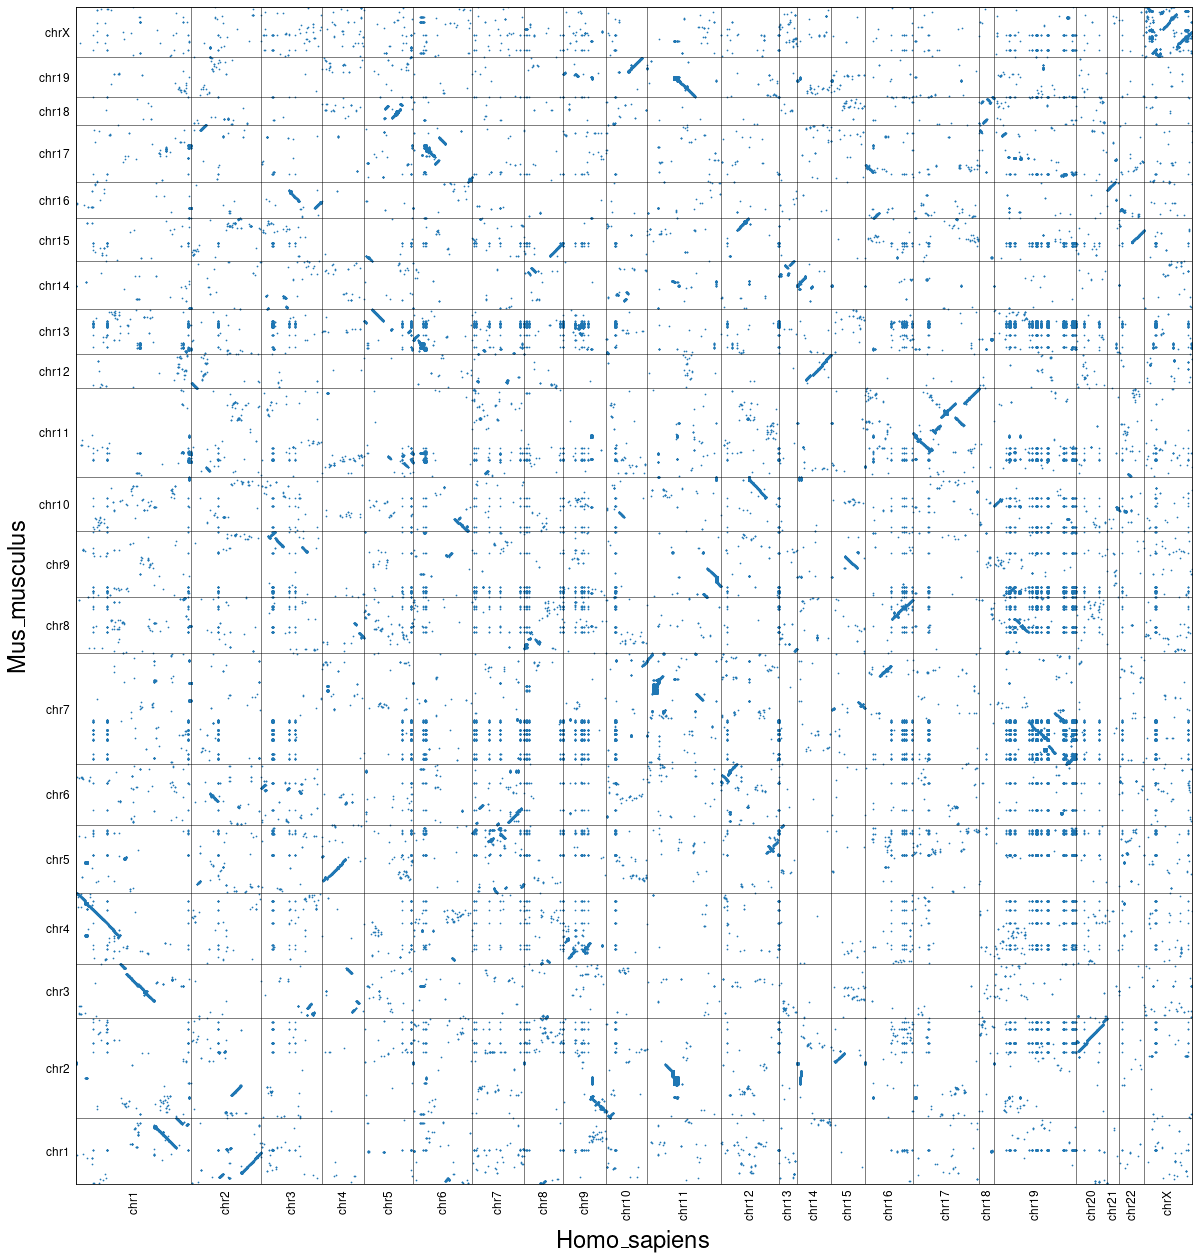

In [556]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,label1=spA,label2=spB)

In [380]:
maps_A = create_shift_map(species_data_A, 1)
maps_B = create_shift_map(species_data_B, 1)
shifted_dots = shift_dots(dot_plot, species_data_A, species_data_B, maps_A, maps_B)

In [441]:
H_mat = convert_dot_plot_to_homology_matrix(dot_plot, chrom_info_A, chrom_info_B)

In [468]:
chromsA = alphanum_sort(list(chrom_info_A.keys()))  
chromsB = alphanum_sort(list(chrom_info_B.keys()))

In [470]:
genesA = species_data_A[species_data_A[:,0] == chromA]  
genesB = species_data_B[species_data_B[:,0] == chromB]  
ngenesA = genesA.shape[0]
ngenesB = genesB.shape[0]

In [486]:
MA = np.vstack(ngenesB * [genesA[:,4:5].T])
MB = np.hstack(ngenesA * [genesB[:,4:5]])
zerosA = 1 - (MA == 0)
zerosB = 1 - (MB == 0)
M = (MA == MB).astype(int) * zerosA * zerosB

In [492]:
chromB

'chr1'

In [496]:
chromsA = alphanum_sort(list(chrom_info_A.keys()))
chromsB = alphanum_sort(list(chrom_info_B.keys()))
homology_matrix = {}
for chromA in chromsA:
    for chromB in chromsB:
        genesA = species_data_A[species_data_A[:,0] == chromA]
        genesB = species_data_B[species_data_B[:,0] == chromB]
        ngenesA = genesA.shape[0]
        ngenesB = genesB.shape[0]
        MA = np.vstack(ngenesB * [genesA[:,4:5].T])
        MB = np.hstack(ngenesA * [genesB[:,4:5]])
        zerosA = 1 - (MA == 0)
        zerosB = 1 - (MB == 0)
        M = (MA == MB).astype(int) * zerosA * zerosB
        homology_matrix[(chromA,chromB)] = csr_matrix(M)

In [548]:
additional_data = [np.ones(DOTS[0].shape[0]),np.ones(DOTS[0].shape[0])]

In [549]:
test_labels = np.array(['chromosome name A', 'relative index A', 'chromosome name B','relative index B', 'empty 1', 'empty 2', 'empty 3', 'empty 4','empty 5'])
DOTS = convert_homology_matrix_to_dot_plot(homology_matrix, labels = test_labels, additional_data = additional_data)

In [553]:
DOTS[0][0]

array(['chr1', '5', 'chr1', '311', '1.0', '1.0', '', '', ''], dtype='<U32')

In [555]:
alphanum_sort([str(i) for i in [1,2,3,7,6,5]])

['1', '2', '3', '5', '6', '7']

In [500]:
convert_homology_matrix_to_dot_plot?

In [501]:
np.array(['chromosome name A','relative index A','chromosome name B','relative index B','empty 1','empty 2','empty 3','empty 4','empty 5'])

array(['chromosome name A', 'relative index A', 'chromosome name B',
       'relative index B', 'empty 1', 'empty 2', 'empty 3', 'empty 4',
       'empty 5'], dtype='<U17')

In [466]:
species_data_labels_A

array(['chromosome name', 'chromosome number', 'relative index',
       'absolute index', 'orthogroup', 'gene name', 'MAKER gene label',
       'tandem dup', 'H-w10', 'tandem H-w10', 'empty 4', 'empty 5'],
      dtype='<U17')

In [467]:
species_data_A

array([['chr1', '1', '1', ..., '3.121928094887362', '', ''],
       ['chr1', '1', '2', ..., '3.121928094887362', '', ''],
       ['chr1', '1', '3', ..., '3.188594761554029', '', ''],
       ...,
       ['chrX', '23', '857', ..., '3.121928094887362', '', ''],
       ['chrX', '23', '858', ..., '3.121928094887362', '', ''],
       ['chrX', '23', '859', ..., '3.121928094887362', '', '']],
      dtype='<U23')

In [445]:
H_mat[('chr1', 'chr1')]

<2061x1207 sparse matrix of type '<class 'numpy.float64'>'
	with 811 stored elements in Compressed Sparse Row format>

In [449]:
TEST = assemble_dotplot_chrom_permutations(H_mat)

In [461]:
np.block(TEST)

ValueError: Mismatched array shapes in block along axis 1.

In [385]:
chromA = 'chr1'
chromB = 'chr1'
shifted_dots_AB = shifted_dots[(shifted_dots[:,0] == chromA)*(shifted_dots[:,2] == chromB)]
H = np.zeros((chrom_info_A[chromA]['size'],chrom_info_B[chromB]['size']))
H[shifted_dots_AB[:,1].astype(int)-1,shifted_dots_AB[:,3].astype(int)-1] = 1

In [403]:
Mr = nanosynteny_convolve_dot_plot(H,3)
if Mr.sum() == 0:
    pass
else:
    R = convolve_deconvolve_maxdist_dot_plot(Mr, H, 3)
    n_active_dots = R.sum()
    while True:
        R = convolve_deconvolve_maxdist_dot_plot(R, H, 3)
        if R.sum() == n_active_dots:
            break
        else:
            n_active_dots = R.sum()
    xr, yr = np.where(R == 1)
    shifted_dots_AB = np.vstack([np.array(xr.shape[0]*[chromA]),xr+1,np.array(yr.shape[0]*[chromB]),yr+1]).T
    blocks_AB = identify_blocks_chrom_pair(shifted_dots_AB,3,3,maps_A,maps_B)

(925.0, 975.0)

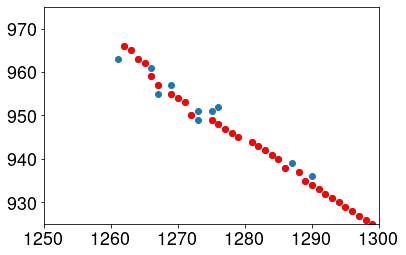

In [409]:
plt.scatter(shifted_dots_AB[:,1].astype(int),shifted_dots_AB[:,3].astype(int))
for block in blocks_AB:
    plt.scatter(block[:,1].astype(int),block[:,3].astype(int),c='r')
plt.xlim([1250,1300])
plt.ylim([925,975])

In [389]:
H.shape

(2061, 1207)

In [388]:
NANO.shape

(2061, 1207)

In [392]:
HX, HY = np.where(H == 1)
NX, NY = np.where(NANO == 1)

(925.0, 975.0)

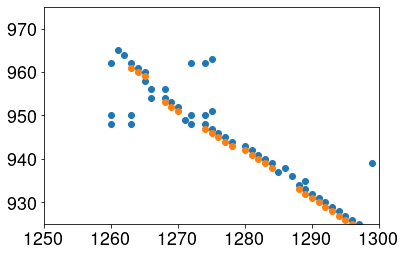

In [399]:
plt.scatter(HX,HY)
plt.scatter(NX,NY)
plt.xlim([1250,1300])
plt.ylim([925,975])

## Nanosynteny

In [10]:
params = {}
params['dot_maxdist'] = 1
params['block_minsize'] = 2
params['dist_cutoff'] = 1
params['return_absolute_blocks'] = True

if 'nano_blocks' not in vars():
    nano_blocks = run_synteny_identification(dot_plot,species_data_A,species_data_B,chrom_info_A,chrom_info_B,params)

In [11]:
h_nano = np.unique([b.shape[0] for b in nano_blocks],return_counts=True)

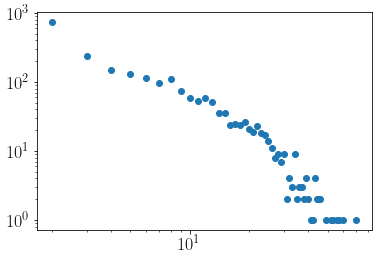

In [38]:
plt.scatter(h_nano[0],h_nano[1])
plt.xscale('log')
plt.yscale('log')

## Microsynteny

In [13]:
params = {}
params['dot_maxdist'] = 3
params['block_minsize'] = kmin
params['dist_cutoff'] = 30

if 'micro_blocks' not in vars():
    micro_blocks = run_synteny_identification(dot_plot,species_data_A,species_data_B,chrom_info_A,chrom_info_B,params)

In [212]:
h_micro = np.unique([b.shape[0] for b in micro_blocks],return_counts=True)

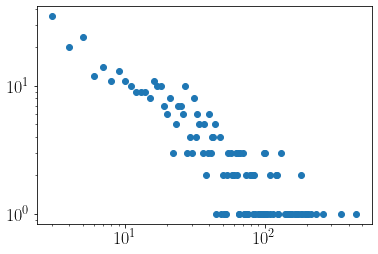

In [213]:
plt.scatter(h_micro[0],h_micro[1])
plt.xscale('log')
plt.yscale('log')

## Dot plot with microsynteny

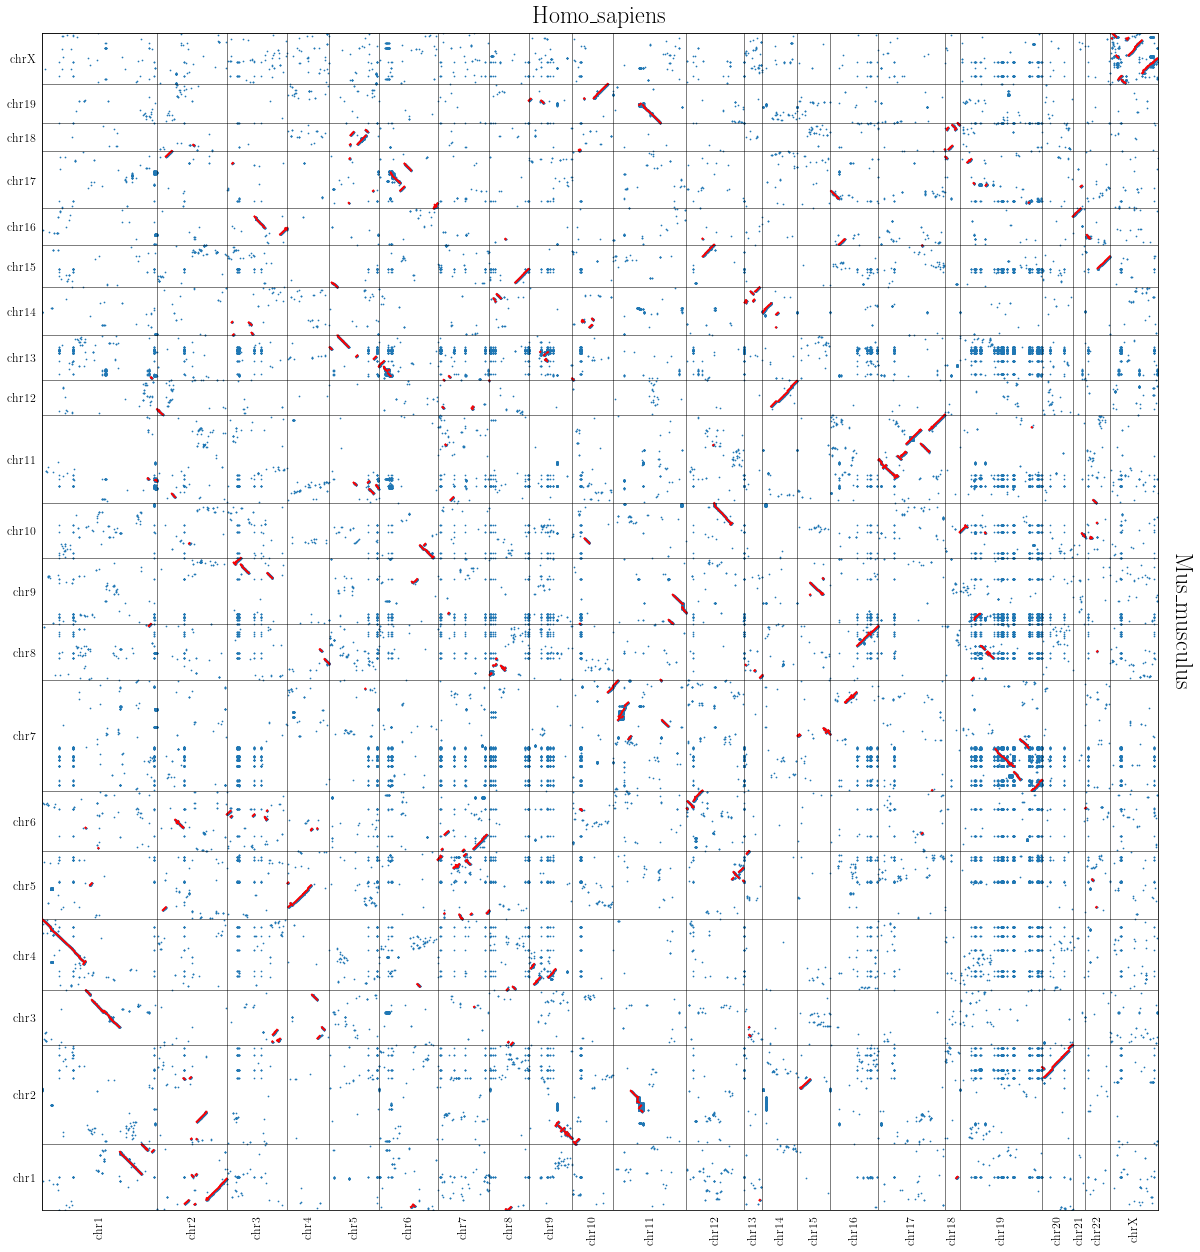

In [214]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,synteny_blocks=micro_blocks,label1=spA,label2=spB)

# Statistical significance of nanosynteny

In [60]:
params = {}
params['dot_maxdist'] = 1
params['block_minsize'] = 2
params['dist_cutoff'] = 1
params['return_absolute_blocks'] = True

if ('permuted_dot_plots' not in vars()) or ('pearson_with_perm' not in vars()) or ('permutation_block_matrix' not in vars()):
    homology_matrix = convert_dot_plot_to_homology_matrix(dot_plot, chrom_info_A, chrom_info_B)
    permuted_dot_plots = {}
    pearson_with_perm = []
    permutation_block_matrix = np.zeros([11,11])
    for nk, kperms in enumerate(range(0,31,3)):
        perm_A, perm_B = generate_permutations(homology_matrix,kperms)
        permuted_homology_matrix, permuted_species_data_A, permuted_species_data_B, pearson = permute_homology_matrix(homology_matrix,species_data_A,species_data_B,perm_A,perm_B)
        permuted_dot_plot = convert_homology_matrix_to_dot_plot(permuted_homology_matrix)
        permuted_dot_plots[kperms] = np.copy(permuted_dot_plot)
        permuted_blocks = run_synteny_identification(permuted_dot_plot,permuted_species_data_A,permuted_species_data_B,chrom_info_A,chrom_info_B,params)
        h_perm = np.unique([b.shape[0] for b in permuted_blocks],return_counts=True)
        h_perm_size = h_perm[0][h_perm[0] < 11]
        h_perm_count = h_perm[1][h_perm[0] < 11]
        print(nk,kperms,h_perm_size,h_perm_count)
        permutation_block_matrix[nk,h_perm_size] = h_perm_count
        pearson_with_perm.append(pearson)
    pearson_with_perm = np.vstack(pearson_with_perm)

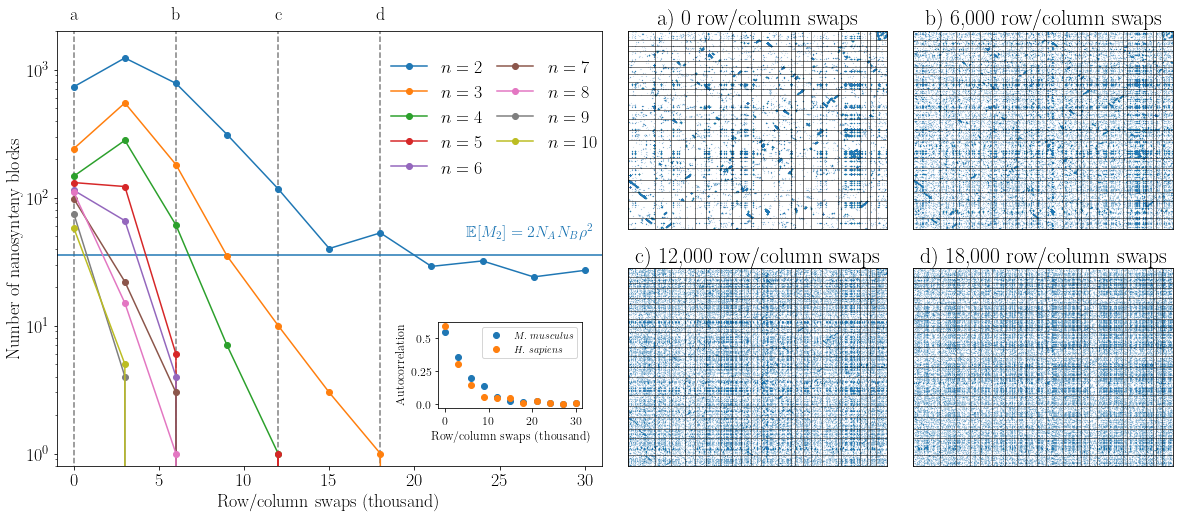

In [62]:
f = plt.figure(figsize=(20,8))
gs = plt.GridSpec(2, 4, figure=f)

ax1 = f.add_subplot(gs[:, :2])
for n in range(2,11):
    ax1.plot(np.arange(0,31,3),permutation_block_matrix[:,n],'-o',label=r'$n=%i$'%n)
ax1.plot([-2,32],[2*N_A*N_B*rho**2,2*N_A*N_B*rho**2],c='C0',zorder=-5)
ax1.legend(loc=(.6,.65),ncol=2,frameon=False,columnspacing=0.8)
ax1.set_yscale('log')
ax1.set_xlabel(r'Row/column swaps (thousand)')
ax1.set_ylabel(r'Number of nanosynteny blocks')
ax1.text(23,50,r'$\mathbb{E}[M_{2}]=2N_{A}N_{B}\rho^{2}$',fontsize=16,c='C0')
ax1.set_xlim(-1,31)
ax1.set_ylim(.8,2e3)
ax1.plot([0,0],[.1,1e4],'--',c='k',alpha=.5,zorder=-10)
ax1.text(0,2.5e3,r'a',horizontalalignment='center')
ax1.plot([6,6],[.1,1e4],'--',c='k',alpha=.5,zorder=-10)
ax1.text(6,2.5e3,r'b',horizontalalignment='center')
ax1.plot([12,12],[.1,1e4],'--',c='k',alpha=.5,zorder=-10)
ax1.text(12,2.5e3,r'c',horizontalalignment='center')
ax1.plot([18,18],[.1,1e4],'--',c='k',alpha=.5,zorder=-10)
ax1.text(18,2.5e3,r'd',horizontalalignment='center')

ax_inset = f.add_axes([.39,.225,.1,.15])
ax_inset.scatter(np.arange(0,31,3),pearson_with_perm[:,2],label=r'$M.~musculus$')
ax_inset.scatter(np.arange(0,31,3),pearson_with_perm[:,3],label=r'$H.~sapiens$')
ax_inset.set_xlabel(r'Row/column swaps (thousand)',fontsize=12)
ax_inset.set_ylabel(r'Autocorrelation',fontsize=12)
ax_inset.set_xticks([0,10,20,30])
ax_inset.set_xticklabels(['0','10','20','30'],fontsize=12)
ax_inset.set_yticks([0,.25,.5])
ax_inset.set_yticklabels(['0.0','0.25','0.5'],fontsize=12)
ax_inset.legend(frameon=True,fontsize=10)

ax2 = f.add_subplot(gs[0, 2])
make_dot_plot_figure(permuted_dot_plots[0],chrom_info_A,chrom_info_B,ax=ax2,dot_size=.005,chrom_labels_A=23*[''],chrom_labels_B=20*[''])
ax2.set_title(r'a) 0 row/column swaps')

ax3 = f.add_subplot(gs[0, 3])
make_dot_plot_figure(permuted_dot_plots[6],chrom_info_A,chrom_info_B,ax=ax3,dot_size=.005,chrom_labels_A=23*[''],chrom_labels_B=20*[''])
ax3.set_title(r'b) 6,000 row/column swaps')

ax4 = f.add_subplot(gs[1, 2])
make_dot_plot_figure(permuted_dot_plots[12],chrom_info_A,chrom_info_B,ax=ax4,dot_size=.005,chrom_labels_A=23*[''],chrom_labels_B=20*[''])
ax4.set_title(r'c) 12,000 row/column swaps')

ax5 = f.add_subplot(gs[1, 3])
make_dot_plot_figure(permuted_dot_plots[18],chrom_info_A,chrom_info_B,ax=ax5,dot_size=.005,chrom_labels_A=23*[''],chrom_labels_B=20*[''])
ax5.set_title(r'd) 18,000 row/column swaps')

f.subplots_adjust(wspace=.1)

#plt.savefig('permutation_test.png',dpi=300,bbox_inches='tight',facecolor='w')

# Saving results - run this cell after all others are finished

In [243]:
if not os.path.isfile('Homo_sapiens-Mus_musculus_synteny_block_results.pkl'):
    pkl.dump([nano_blocks, micro_blocks, nblocks_with_maxdist,synteny_blocks_with_maxdist, synteny_coverage_with_maxdist],open('Homo_sapiens-Mus_musculus_synteny_block_results.pkl','wb'))
if not os.path.isfile('Homo_sapiens-Mus_musculus_permutation_results.pkl'):
    pkl.dump([pearson_with_perm, permutation_block_matrix],open('Homo_sapiens-Mus_musculus_permutation_results.pkl','wb'))
    for maxdist in permuted_dot_plots.keys():
        save_dot_plot('Homo_sapiens-Mus_musculus-permuted_dotplot_%i_swaps.csv'%maxdist,spA,spB,permuted_dot_plots[maxdist],gzip_file=True)